# Allstate Severe Insurance Claim Competition: EDA

_Description: contains my summary statistics for the [Allstate Severe Insurance Claim Competition](https://www.kaggle.com/c/allstate-claims-severity)._

_Last Updated: 1/4/2016 5:11 PM._

_By: [Michael Rosenberg](https://www.kaggle.com/mmrosenb)._

In [57]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns
import cPickle as cpkl
from sklearn import preprocessing as pp
import matplotlib.pyplot as plt
from IPython.display import display, HTML, Markdown, display #display settings
import warnings #for filtering warnings

#constants
%matplotlib inline
sns.set_style("dark")
#to ignore warnings in output
warnings.filterwarnings('ignore')
#global information settings
sigLev = 2 #three significant digits
percentMul = 100 #for percentage multiplication
figWidth = figHeight = 8

In [11]:
#load in dataset
trainFrame = pd.read_csv("../data/train.csv")

We see that there are {{trainFrame.shape[0]}} observations in our dataset and {{trainFrame.shape[1] - 2}} features for our dataset.

## Univariate Analysis

### Target Variable Analysis

Let us start by studying some aspects of the target variable, `loss`.

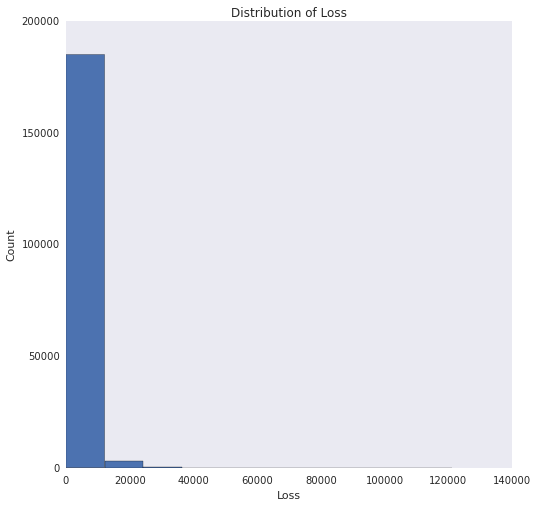

In [12]:
lossFigure = plt.figure(figsize = (figWidth,figHeight))
lossHistogram = plt.hist(trainFrame["loss"])
plt.xlabel("Loss")
plt.ylabel("Count")
plt.title("Distribution of Loss")

_Figure 1: Distribution of our target variable `loss` across our training set._

It is apparent that our target variable is extremely right-skewed. It may be preferable for us to target a more favorably-distributed variable. Let us study $\log(loss).$

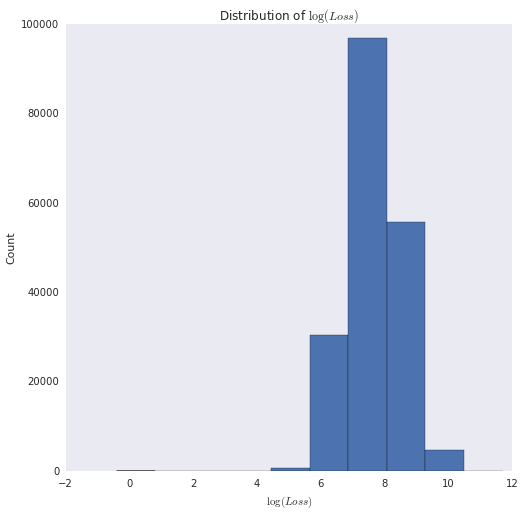

In [13]:
trainFrame["logLoss"] = np.log(trainFrame["loss"])
logLossFigure = plt.figure(figsize = (figWidth,figHeight))
logLossHistogram = plt.hist(trainFrame["logLoss"])
plt.xlabel("$\log(Loss)$")
plt.ylabel("Count")
plt.title("Distribution of $\log(Loss)$")

_Figure 2: Distribution of the log of our `loss` variable._

Interestingly, we see an outcome with $\log(Loss)$ of $-0.4$, or around $e^{-0.4} = .67$ in loss claim. This seems to be an unusual outlier and is likely not a strong representation of the distribution overall. We see that most of our observations are centered around a loss claim of $e^7 \approx 1100.$ If this is scaled in dollars, this actually a relatively moderate loss claim. That being said, since the competition does not specify the loss measurement, it is difficult to confirm this suggestion.

### Categorical Variable Summary Statistics

Let us get a sense of some of the distributions of our categorical variables

In [14]:
#check number of categorical variables
categoricalColumns = [col for col in trainFrame.columns if "cat" in col]

We see that there are {{len(categoricalColumns)}} categorical variables in this dataset.

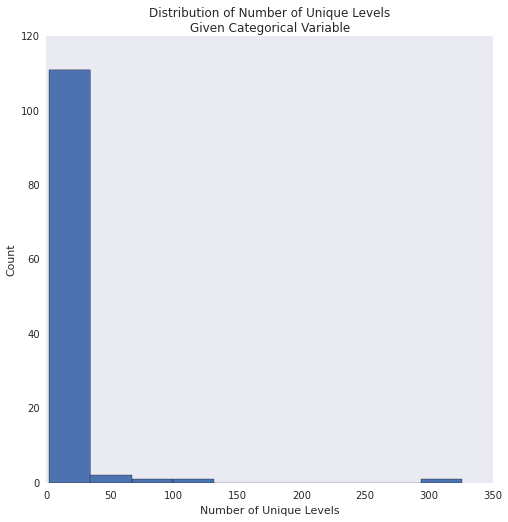

In [15]:
#get num unique for each
categoricalTrainFrame = trainFrame[categoricalColumns]
uniqueVec = categoricalTrainFrame.apply(lambda x : x.nunique(),axis = 0)
nuniqueMode = uniqueVec.mode()
#then plot the distribution of number of unique levels
categoricalUniqueFigure = plt.figure(figsize = (figWidth,figHeight))
categoricalNUniqueHist = plt.hist(uniqueVec)
plt.xlabel("Number of Unique Levels")
plt.ylabel("Count")
plt.title("Distribution of Number of Unique Levels\nGiven Categorical Variable")

_Figure 3: Distribution of the number of unique levels for a categorical variable._

We see an extreme right skew in the distribution of the number of unique levels. The mode number of unique levels is {{int(nuniqueMode)}}, while we hae some observations that range near 300 levels. This suggests that there may be some usability issues related to some variables with high amounts of levels. That being said, there are relatively few of them, which suggests that we will probably be in the clear on these level issues for the most part.

Let us check to see if there are any very low variance categorical features.

In [16]:
#make mapper functions
def integerizeCol(catColumn):
    #helper for integerizing a categorical column
    levels = catColumn.unique()
    counter = 0
    mapDict = {} #will add to this
    for lev in levels:
        mapDict[lev] = counter
        counter += 1
    #then integerize the column
    intCol = catColumn.map(mapDict)
    return intCol

def propMode(catColumn):
    #helper that finds the proportion of a given column is the mode
    #integerize it
    intCatColumn = integerizeCol(catColumn)
    #then get the mode
    modeOfCategory = int(intCatColumn.mode())
    #then get proportion
    numMode = intCatColumn[intCatColumn == modeOfCategory].shape[0]
    propMode = float(numMode) / intCatColumn.shape[0]
    return propMode
#then apply over categorical columns
propModeVec = categoricalTrainFrame.apply(propMode,axis = 0)

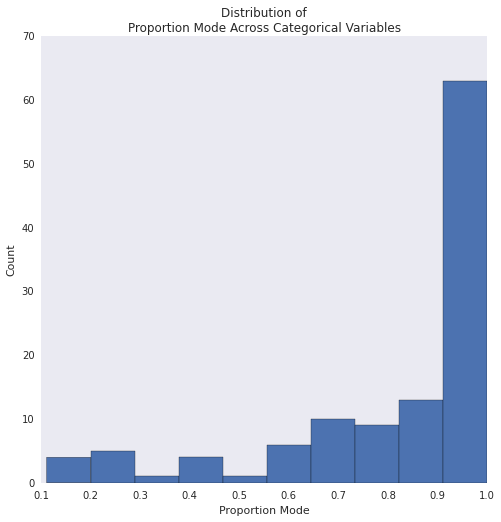

In [17]:
#then plot
givenFigure = plt.figure(figsize = (figWidth,figHeight))
plt.hist(propModeVec)
plt.xlabel("Proportion Mode")
plt.ylabel("Count")
plt.title("Distribution of\nProportion Mode Across Categorical Variables")

_Figure 4: Distribution of mode proportions across categorical variables._

We see that many of our categorical variables are low in variance, as around $60$ categorical variables have their modes taking up over $90\%$ of their distribution. This may suggest that we will have to consider removing many low variance features from consideration. For initial interpretation, we will not consider any variables with fewer than $100$ observations not in the mode. In the future, we may consider extending this to more low-variance features.

In [18]:
categoricalCutoff = 100 #won't consider categorical variables with fewer than
#this amount of features
propModeBelowCutoff = (
    propModeVec[(1 - propModeVec) * trainFrame.shape[0] < categoricalCutoff])
catToRemove = list(propModeBelowCutoff.index)
categoricalColumns = [catCol for catCol in categoricalColumns if
                        catCol not in catToRemove]

### Continuous Variable Summary Statistics

We will now study some aspects of our continuous variables.

In [19]:
#get continuous variables
continuousColumns = [col for col in trainFrame.columns if "cont" in col]

We have {{len(continuousColumns)}} continuous variables in our dataset.

In [20]:
#get standard deviations of continuous columns
continuousTrainFrame = trainFrame[continuousColumns]
continuousVarVec = continuousTrainFrame.apply(lambda x: x.std(),axis = 0)
display(continuousVarVec)

cont1     0.187640
cont2     0.207202
cont3     0.202105
cont4     0.211292
cont5     0.209027
cont6     0.205273
cont7     0.178450
cont8     0.199370
cont9     0.181660
cont10    0.185877
cont11    0.209737
cont12    0.209427
cont13    0.212777
cont14    0.222488
dtype: float64

_Table 1: Our continuous variables by their sample standard errors._

Given that our continuous variables have been normalized to between $0$ and $1$, these standard errors for our continuous variables are very reasonable. Thus, I am doubtful that we will have to worry about low-variance features when dealing with continuous variables.

### Check for Missing Values

In [21]:
def numNull(colVec):
    #helper that gets the number of null values in a given columns
    nullValColVec = colVec[colVec.isnull()]
    return nullValColVec.shape[0]
numMissingVec = trainFrame.apply(numNull,axis = 0)
anyMissing = (numMissingVec.sum() > 0)

To our benefit, there are no missing values in this table. The wonders of cleaned data!

## Bivariate Analysis

Let us consider the variables that have non-trivial correlation with our `logLoss` variable.

In [22]:
#reencode our categorical variables
intTrainFrame = trainFrame
intTrainFrame = intTrainFrame.loc[:,
                                  ~trainFrame.columns.isin(categoricalColumns)]
for catCol in categoricalColumns:
    intTrainFrame["int_" + catCol] = integerizeCol(trainFrame[catCol])

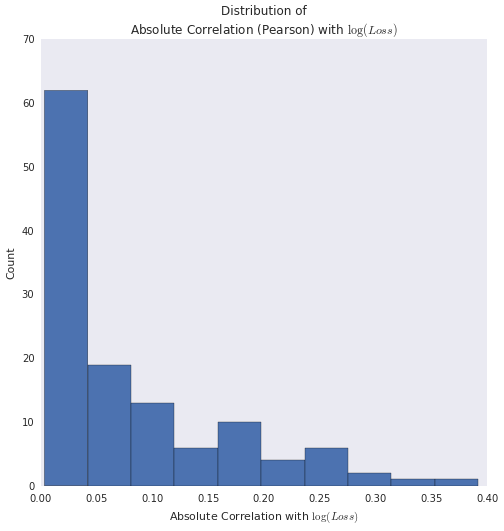

In [23]:
#check for correlations
trainCorFrame = intTrainFrame.corr()
#clear up irrelevant variable
trainCorFrame = trainCorFrame.drop(["id","loss"],axis=0)
trainCorFrame = trainCorFrame.drop(["id","loss"],axis=1)
#then get relevant vector
logLossCorVec = trainCorFrame.loc["logLoss",:]
logLossCorVec = logLossCorVec.drop("logLoss",axis = 0)
logLossAbsCorVec = abs(logLossCorVec)
#then plot it
givenFigure = plt.figure(figsize = (figWidth,figHeight))
plt.hist(logLossAbsCorVec)
plt.ylabel("Count")
plt.xlabel("Absolute Correlation with $\log(Loss)$")
plt.title("Distribution of\nAbsolute Correlation (Pearson) with $\log(Loss)$")

_Figure 5: Distribution of the absolute correlation between $\log(Loss)$ and our variables._

As expected, we see a severely right-skewed distribution, with many variables having little to no correlation with $|\log(Loss)|$ and a long tail of variables have rather high absolute correlations with $\log(Loss).$  I generally prefer to look at variables with absolute correlations with the target at above $.1$, but given the large number of variables that have close to $0$ absolute correlation with our target variable, I would think that reducing features solely based on low absolute correlation may be a poor decision. Hence, for model selection purposes, I will likely attempt to add these covariates back in for out-of-sample prediction purposes.

Let us study our top $5$ features in terms of absolute correlation with $\log(Loss)$.

In [24]:
#order absolute correlation vector
logLossAbsCorVec = logLossAbsCorVec.sort_values(ascending = False)
#get top 5 features
numFeaturesConsidered = 5
topFiveFeatures = list(logLossAbsCorVec.index)[0:numFeaturesConsidered]
display(topFiveFeatures)

['int_cat80', 'int_cat12', 'int_cat87', 'int_cat10', 'int_cat1']

_Table 2: The $5$ features that have the highest absolute correlation with $\log(Loss)$._

Intersetingly, our $5$ features with highest absolute correlation with $\log(Loss)$ happen to be categorical variables. This may simply be a mathematical anomaly, since the continuous variables are limited to the $[0,1]$ scale, this is perhaps a mathematical anomaly of the variable domains.

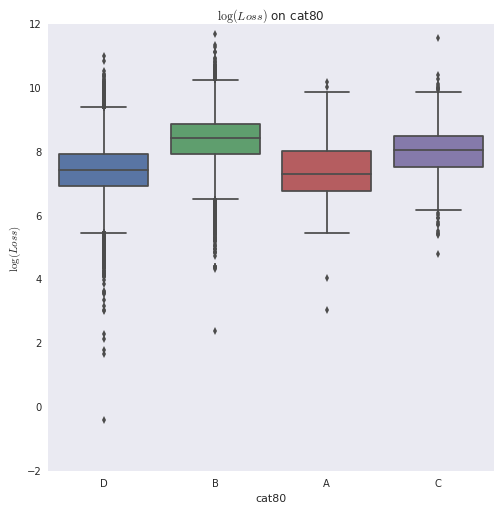

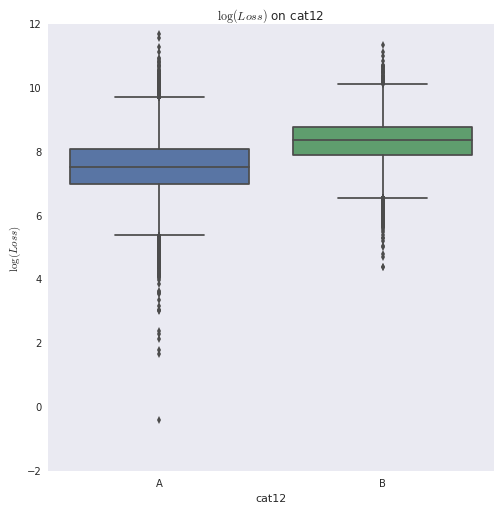

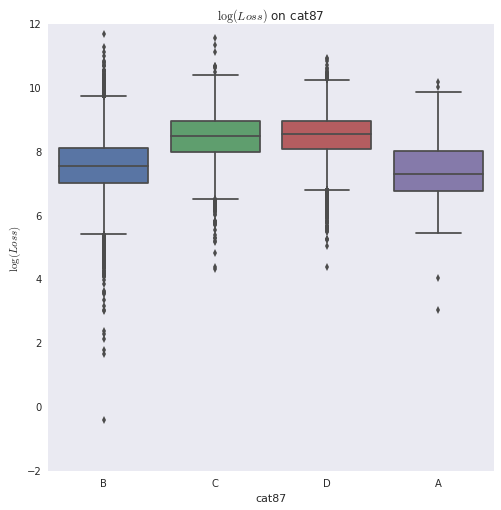

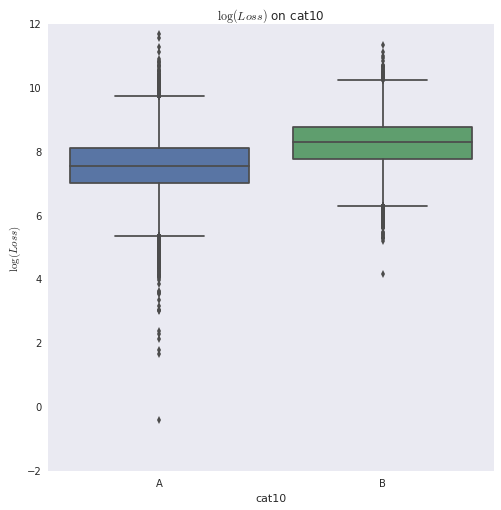

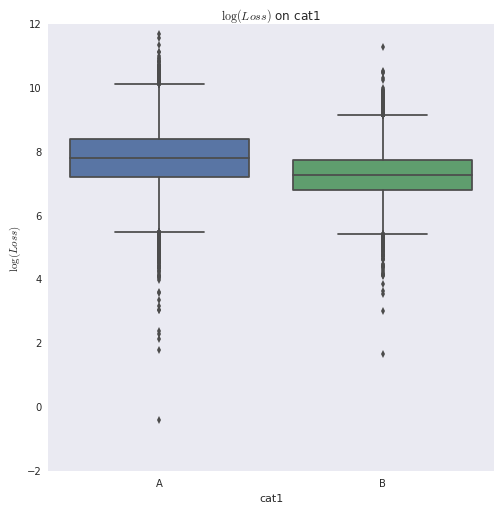

In [25]:
#clean up feature names for full train frame
def plotCategory(catName):
    #helper for plotting our categories
    figure = plt.figure(figsize = (figWidth,figHeight))
    newBoxplot = sns.boxplot(x = catName,y = "logLoss",data = trainFrame)
    #then set labels
    sns.plt.xlabel(catName)
    sns.plt.ylabel("$\log(Loss)$")
    sns.plt.title("$\log(Loss)$ on " + catName)
topFiveFilteredFeatures = [feat[len("int_"):] for feat in topFiveFeatures]
for category in topFiveFilteredFeatures:
    plotCategory(category)

_Figure 6: Boxplots of $\log(Loss)$ given particular levels of the top five categories for absolute correlation with $\log(Loss)$._

We see that the effects we are considering make meaningful differences on on the inter-quartile range of $\log(Loss)$, but the general five number summary range stays pretty close across all levels of a given category. This suggests to me that the univariate predictive effects will likely be not that strong, and so we will likely need to spend some time considering the interaction effects available across our categories. That being said when you translate our $\log(Loss)$ range to our $Loss$ range, we do see extremely meaningful effects towards the median of each categorical level.

For the sake of reference, let's save the top 30 features that are correlated with $\log(Loss).$

In [56]:
#get top thirty correlated features
numFeaturesConsidered = 30
topThirtyFeatures = list(logLossAbsCorVec.index)[0:numFeaturesConsidered]
#clean features
for i in xrange(len(topThirtyFeatures)):
    if ("int_" in topThirtyFeatures[i]): #clean it
        topThirtyFeatures[i] = topThirtyFeatures[i][len("int_"):]
print topThirtyFeatures

['cat80', 'cat12', 'cat87', 'cat10', 'cat1', 'cat2', 'cat79', 'cat9', 'cat11', 'cat72', 'cat13', 'cat81', 'cat57', 'cat7', 'cat89', 'cat3', 'cat16', 'cat90', 'cat23', 'cat73', 'cat103', 'cat36', 'cat6', 'cat50', 'cat111', 'cat5', 'cat28', 'cat40', 'cat4', 'cat38']


In [59]:
#then export
featureList = open("../data/featureList.pkl","wb")
cpkl.dump(topThirtyFeatures,featureList)
featureList.close()